In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from bisect import bisect_left
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [44]:
order_currency = pd.read_csv('/Users/rashimohta/Documents/UCB MFE/Semester 3/230X/Homework/Data Currency/ORDER CURRENCY.csv')
trade_currency = pd.read_csv('/Users/rashimohta/Documents/UCB MFE/Semester 3/230X/Homework/Data Currency/TRADE CURRENCY.csv')
order_currency['Time'] = pd.to_datetime(order_currency['Time'])
trade_currency['Time'] = pd.to_datetime(trade_currency['Time'])

In [45]:
# Orderbook creation
def create_orderbook(df, currency_pair):
    orderbook = {}
    current_orderbook = {"bid": [], "ask": []}
    current_time = datetime(2012, 1, 25, 9, 30, 0)
    end_time = datetime(2012, 1, 25, 16, 0, 0)

    relevant_columns = [x for x in df.columns if currency_pair in x and
                        not any(term in x for term in ['DELETED', 'NUM_PARTCP', 'TICK_STATUS', 'RECORD_TYPE', 'OMDSEQ'])]
    
    for ts, bs, price, amt in df[['Time'] + relevant_columns].dropna().values:
        while current_time < ts:
            orderbook[current_time.strftime("%Y/%m/%d %H:%M:%S")] = deepcopy(current_orderbook)
            current_time += timedelta(seconds=1)

        side = 'ask' if bs else 'bid'
        price = -price if side == 'bid' else price
        idx = bisect_left(current_orderbook[side], [price, 0])

        if amt == 0:
            if idx < len(current_orderbook[side]) and current_orderbook[side][idx][0] == price:
                del current_orderbook[side][idx]
        elif idx < len(current_orderbook[side]) and current_orderbook[side][idx][0] == price:
            current_orderbook[side][idx][1] = amt
        else:
            current_orderbook[side].insert(idx, [price, amt])

    while current_time < end_time:
        orderbook[current_time.strftime("%Y/%m/%d %H:%M:%S")] = deepcopy(current_orderbook)
        current_time += timedelta(seconds=1)

    for k in orderbook:
        orderbook[k]['bid'] = [[abs(x[0]), x[1]] for x in orderbook[k]['bid']]

    return orderbook

In [46]:
# Data processing
def process_currency_data(order_currency):
    currency_pairs = ['EUR/USD', 'USD/JPY', 'EUR/JPY']
    currency_orderbook = {pair: create_orderbook(order_currency, pair) for pair in currency_pairs}
    
    dfs_order_curr = {}
    for pair in currency_pairs:
        df = []
        for t, book in currency_orderbook[pair].items():
            bid, ask = book['bid'], book['ask']
            for i in range(max(len(bid), len(ask))):
                df.append({
                    "Time": t,
                    "BID_PRICE": bid[i][0] if i < len(bid) else None,
                    "BID_SIZE": bid[i][1] if i < len(bid) else None,
                    "ASK_PRICE": ask[i][0] if i < len(ask) else None,
                    "ASK_SIZE": ask[i][1] if i < len(ask) else None,
                    "LEVEL": i+1
                })
        dfs_order_curr[pair] = pd.DataFrame(df)
        dfs_order_curr[pair]['Time'] = pd.to_datetime(dfs_order_curr[pair]["Time"])
        dfs_order_curr[pair].set_index('Time', inplace=True)
    
    return currency_orderbook, dfs_order_curr

In [47]:
# Data cleaning
def clean_and_split_data(df, tickers, header):
    df.columns = [x.replace(header, "").replace("..Price", "") for x in df.columns]
    return {tick: df.loc[:, ['Time'] + [item for item in df.columns if tick in item]]
                .rename(columns=lambda x: x.replace(f'{tick}.', ""))
                .set_index('Time')
            for tick in tickers}
dfs_trade_curr = clean_and_split_data(trade_currency,['EUR/USD','USD/JPY','EUR/JPY'],"EBS_BOOK::")

Analysis Functions

In [48]:
def calculate_dollar_volume(trade_df, ticker):
    trade_df['Dollar_Volume_TradCurr'] = trade_df['PRICE'] * trade_df['SIZE']
    
    if ticker == 'USD/JPY':
        trade_df['Dollar_Volume_USD'] = trade_df['SIZE']
    elif ticker == 'EUR/JPY':
        temp = dfs_order_curr['USD/JPY'][['BID_PRICE', 'ASK_PRICE']]
        temp['midquote'] = (temp['BID_PRICE'] + temp['ASK_PRICE']) / 2
        trade_df = pd.merge_asof(trade_df, temp[['midquote']], on='Time', direction='backward').dropna()
        trade_df['Dollar_Volume_USD'] = trade_df['SIZE'] * trade_df['PRICE'] / trade_df['midquote']
        trade_df.set_index('Time', inplace=True)
    else:
        trade_df['Dollar_Volume_USD'] = trade_df['Dollar_Volume_TradCurr']
    
    return trade_df

In [49]:
def analyze_trading_activity(trade_df, order_df):
    numTrade = trade_df['SIZE'].resample('T').count().rename('numTrade')
    tradedShares = trade_df['SIZE'].resample('T').sum().rename('numTrade_shares')
    
    orderShares = order_df.resample('5s')[['BID_SIZE', 'ASK_SIZE']].sum()
    orderShares['bid_diff'] = orderShares['BID_SIZE'].diff(1)
    orderShares['ask_diff'] = orderShares['ASK_SIZE'].diff(1)
    orderShares['numOrder_Shares'] = orderShares['bid_diff'].abs() + orderShares['ask_diff'].abs()
    orderShares = orderShares['numOrder_Shares'].resample('T').sum()
    
    return pd.concat([numTrade, tradedShares, orderShares], axis=1)

In [50]:
def calculate_ohlc(trade_df):
    return pd.DataFrame({
        'open': [trade_df['PRICE'].iloc[0]],
        'close': [trade_df['PRICE'].iloc[-1]],
        'high': [trade_df['PRICE'].max()],
        'low': [trade_df['PRICE'].min()]
    })

In [51]:
def calculate_vwap(trade_df):
    dollar_volume = (trade_df['PRICE'] * trade_df['SIZE']).resample('T').sum()
    volume = trade_df['SIZE'].resample('T').sum()
    return (dollar_volume / volume).rename('VWAP')


In [52]:
def analyze_bbo(order_df):
    bbo = order_df[order_df['LEVEL'] == 1].copy()
    bbo['spread'] = bbo['ASK_PRICE'] - bbo['BID_PRICE']
    return bbo.resample('T')[['spread', 'BID_SIZE', 'ASK_SIZE', 'ASK_PRICE', 'BID_PRICE']].mean()

In [53]:
def calculate_depth_at_twice_spread(order_df, bbo_df):
    bbo_df["midquote"] = (bbo_df["ASK_PRICE"] + bbo_df["BID_PRICE"])/2
    order_df = order_df.merge(bbo_df[['midquote', 'spread']], on='Time')
    daily_spread = bbo_df['spread'].mean()
    
    order_df['bid_depth_within_range'] = order_df.apply(
        lambda x: x['BID_SIZE'] if x['BID_PRICE'] >= x['midquote'] - daily_spread else 0, axis=1)
    order_df['ask_depth_within_range'] = order_df.apply(
        lambda x: x['ASK_SIZE'] if x['ASK_PRICE'] <= x['midquote'] + daily_spread else 0, axis=1)
    
    return order_df[['bid_depth_within_range', 'ask_depth_within_range']].resample('T').mean()

In [54]:
def calculate_price_impact(trade_df, order_df):
    PI = 2 * trade_df["BUY_SELL_FLAG"] - 1
    level1_order = order_df[order_df['LEVEL'] == 1]
    level1_order['midquote'] = level1_order[['BID_PRICE', 'ASK_PRICE']].mean(axis=1)
    return_midquote = level1_order['midquote'].pct_change()
    
    merged_df = pd.merge_asof(PI, return_midquote.to_frame(), on='Time', direction='backward').dropna()
    model = sm.OLS(merged_df['midquote'], merged_df['BUY_SELL_FLAG']).fit()
    
    return model.summary(), merged_df

In [55]:
def calculate_returns(order_df, trade_df):
    level1_order = order_df[order_df['LEVEL'] == 1]
    level1_order['midquote'] = level1_order[['BID_PRICE', 'ASK_PRICE']].mean(axis=1)

    quote_price = pd.DataFrame()
    quote_price['1min midquote'] = level1_order['midquote'].resample('T').last()
    quote_price['1s midquote'] = level1_order['midquote'].resample('1s').last()
    quote_price['1min transaction price'] = trade_df.resample('T')['PRICE'].last().to_frame()
    quote_price['1s transaction price'] =trade_df.resample('1s')['PRICE'].last().to_frame()

    for col in quote_price.columns:
        quote_price[f'return {col}'] = np.log(quote_price[col]).diff()
    
    return quote_price

Visualization functions

In [56]:
def plot_liquidity_metrics(bbo_df):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    temp = bbo_df.resample('5T').mean()
    temp['spread'].plot(ax=axes[0], title='BBO Spread')
    temp['BID_SIZE'].plot(ax=axes[1], title='BBO Bid Depth')
    temp['ASK_SIZE'].plot(ax=axes[2], title='BBO Ask Depth')
    plt.tight_layout()
    return fig

In [57]:
def plot_price_impact(merged_df):
    def group_price_impact(group):
        if len(group) <= 1:
            return None
        model = sm.OLS(group['midquote'], group['BUY_SELL_FLAG']).fit()
        return model.params[0]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    merged_df.set_index('Time').resample('5T').apply(group_price_impact).plot(ax=ax, title='Price Impact (5min Regression)')
    return fig

In [58]:
def plot_return_metrics(quote_price):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    quote_price['return 1min transaction price'].dropna().resample('30T').var().plot(ax=axes[0], title='Variance')
    
    def group_acf(group):
        acf_computed = acf(group['return 1min transaction price'].dropna())
        return acf_computed[1] if len(acf_computed) > 1 else None
    
    quote_price[['return 1min transaction price']].dropna().resample('30T').apply(group_acf).plot(ax=axes[1], title='1st ACF')
    plt.tight_layout()
    return fig

In [59]:
def plot_acf_pacf(quote_price):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    plot_acf(quote_price['return 1min transaction price'].dropna(), ax=axes[0, 0], title="Trade ACF - 1 Min", lags=np.arange(1, 20))
    plot_pacf(quote_price['return 1min transaction price'].dropna(), ax=axes[0, 1], title="Trade PACF - 1 Min", lags=np.arange(1, 20))
    plot_acf(quote_price['return 1min midquote'].dropna(), ax=axes[1, 0], title="Mid-quote ACF - 1 Min", lags=np.arange(1, 20))
    plot_pacf(quote_price['return 1min midquote'].dropna(), ax=axes[1, 1], title="Mid-quote PACF - 1 Min", lags=np.arange(1, 20))
    plt.tight_layout()
    return fig

In [60]:
# Analyze arbitrage opportunities
def analyze_arbitrage(currency_orderbook):
    current_time = datetime(2012, 1, 25, 9, 30, 0)
    end_time = datetime(2012, 1, 25, 16, 0, 0)
    arbitrage_data = []

    while current_time < end_time:
        time_str = current_time.strftime("%Y/%m/%d %H:%M:%S")
        eurusd = currency_orderbook['EUR/USD'][time_str]
        usdjpy = currency_orderbook['USD/JPY'][time_str]
        eurjpy = currency_orderbook['EUR/JPY'][time_str]

        if eurusd['ask'] and eurjpy['bid'] and usdjpy['ask']:
            arbi_long_eur = 1 / eurusd['ask'][0][0] * eurjpy['bid'][0][0] / usdjpy['ask'][0][0]
            amt_long_eur = min(eurusd['ask'][0][1], usdjpy['ask'][0][1]/usdjpy['ask'][0][0], eurjpy['bid'][0][1]/usdjpy['ask'][0][0]) if arbi_long_eur > 1 else 0
        else:
            arbi_long_eur = None
            amt_long_eur = None

        if eurusd['bid'] and eurjpy['ask'] and usdjpy['bid']:
            arbi_short_eur = eurusd['bid'][0][0] / eurjpy['ask'][0][0] * usdjpy['bid'][0][0]
            amt_short_eur = min(eurusd['bid'][0][1], usdjpy['bid'][0][1]/usdjpy['bid'][0][0], eurjpy['ask'][0][1]/usdjpy['bid'][0][0]) if arbi_short_eur > 1 else 0
        else:
            arbi_short_eur = None
            amt_short_eur = None

        arbitrage_data.append({
            'time': time_str,
            'arbi_by_long_eur': arbi_long_eur,
            'arbi_by_long_eur_amt': amt_long_eur,
            'arbi_by_short_eur': arbi_short_eur,
            'arbi_by_short_eur_amt': amt_short_eur
        })

        current_time += timedelta(seconds=1)

    arbitrage = pd.DataFrame(arbitrage_data)
    arbitrage['time'] = pd.to_datetime(arbitrage['time'])
    arbitrage.set_index('time', inplace=True)
    arbitrage['duration'] = ((arbitrage['arbi_by_long_eur'] > 1) | (arbitrage['arbi_by_short_eur'] > 1)).astype(int)
    arbitrage['group'] = (arbitrage['duration'] == 0).cumsum()
    arbitrage['arbi_amt'] = arbitrage['arbi_by_long_eur_amt'].fillna(0) + arbitrage['arbi_by_short_eur_amt'].fillna(0)
    arbitrage['arbi_ret'] = arbitrage.apply(lambda x: max(x['arbi_by_long_eur'] or 0, x['arbi_by_short_eur'] or 0), axis=1)

    arbitrage_summary = arbitrage[arbitrage['duration'] == 1].groupby('group').agg({
        'duration': 'sum',
        'arbi_amt': 'mean',
        'arbi_ret': 'mean'
    })

    return arbitrage, arbitrage_summary


In [61]:
def analyze_ticker(trade_df, order_df, ticker):
    results = {}
    
    # Calculate dollar volume
    trade_df = calculate_dollar_volume(trade_df, ticker)
    dollar_volume = trade_df.resample('T')[['Dollar_Volume_TradCurr', 'Dollar_Volume_USD']].sum()
    results['dollar_volume'] = dollar_volume.describe()
    
    # Analyze trading activity
    results['trading_activity'] = analyze_trading_activity(trade_df, order_df).describe()
    
    # Calculate OHLC
    results['ohlc'] = calculate_ohlc(trade_df).describe()
    
    # Calculate VWAP
    results['vwap'] = calculate_vwap(trade_df).describe()
    
    # Analyze BBO
    bbo_df = analyze_bbo(order_df)
    results['bbo'] = bbo_df.describe()
    
    # Plot liquidity metrics
    results['liquidity_plot'] = plot_liquidity_metrics(bbo_df)
    
    # Calculate depth at twice spread
    results['depth_at_twice_spread'] = calculate_depth_at_twice_spread(order_df, bbo_df).describe()
    
    # Calculate price impact
    results['price_impact_summary'], merged_df = calculate_price_impact(trade_df, order_df)
    results['price_impact_plot'] = plot_price_impact(merged_df)

    # Calculate returns
    quote_price = calculate_returns(order_df, trade_df)
    results['returns'] = quote_price.describe()
    
    # Calculate realized variance
    results['realized_variance'] = {
        'midquote': (quote_price['return 1min midquote']**2).sum(),
        'transaction_price': (quote_price['return 1min transaction price']**2).sum()
    }

    # Plot ACF and PACF
    results['acf_pacf_plot'] = plot_acf_pacf(quote_price)

    # Return distribution
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    sns.histplot(quote_price['return 1min midquote'].dropna(), kde=True, ax=axes[0])
    axes[0].set_title('Distribution of 1-minute Midquote Returns')
    sns.histplot(quote_price['return 1min transaction price'].dropna(), kde=True, ax=axes[1])
    axes[1].set_title('Distribution of 1-minute Transaction Price Returns')
    plt.tight_layout()
    results['return_distribution_plot'] = fig

    return results



Results for EUR/USD

Dollar Volume Statistics:
       Dollar_Volume_TradCurr  Dollar_Volume_USD
count            3.900000e+02       3.900000e+02
mean             7.935909e+07       7.935909e+07
std              9.879203e+07       9.879203e+07
min              0.000000e+00       0.000000e+00
25%              2.879773e+07       2.879773e+07
50%              5.100539e+07       5.100539e+07
75%              8.859964e+07       8.859964e+07
max              1.166953e+09       1.166953e+09

Trading Activity Statistics:
         numTrade  numTrade_shares  numOrder_Shares
count  390.000000     3.900000e+02     3.900000e+02
mean    37.269231     6.089487e+07     4.377487e+08
std     36.636431     7.571124e+07     5.961196e+08
min      0.000000     0.000000e+00     9.500000e+07
25%     16.000000     2.200000e+07     2.335000e+08
50%     27.000000     3.900000e+07     3.175000e+08
75%     42.000000     6.800000e+07     4.425000e+08
max    340.000000     8.920000e+08     8.289000e+09

OHLC Statist

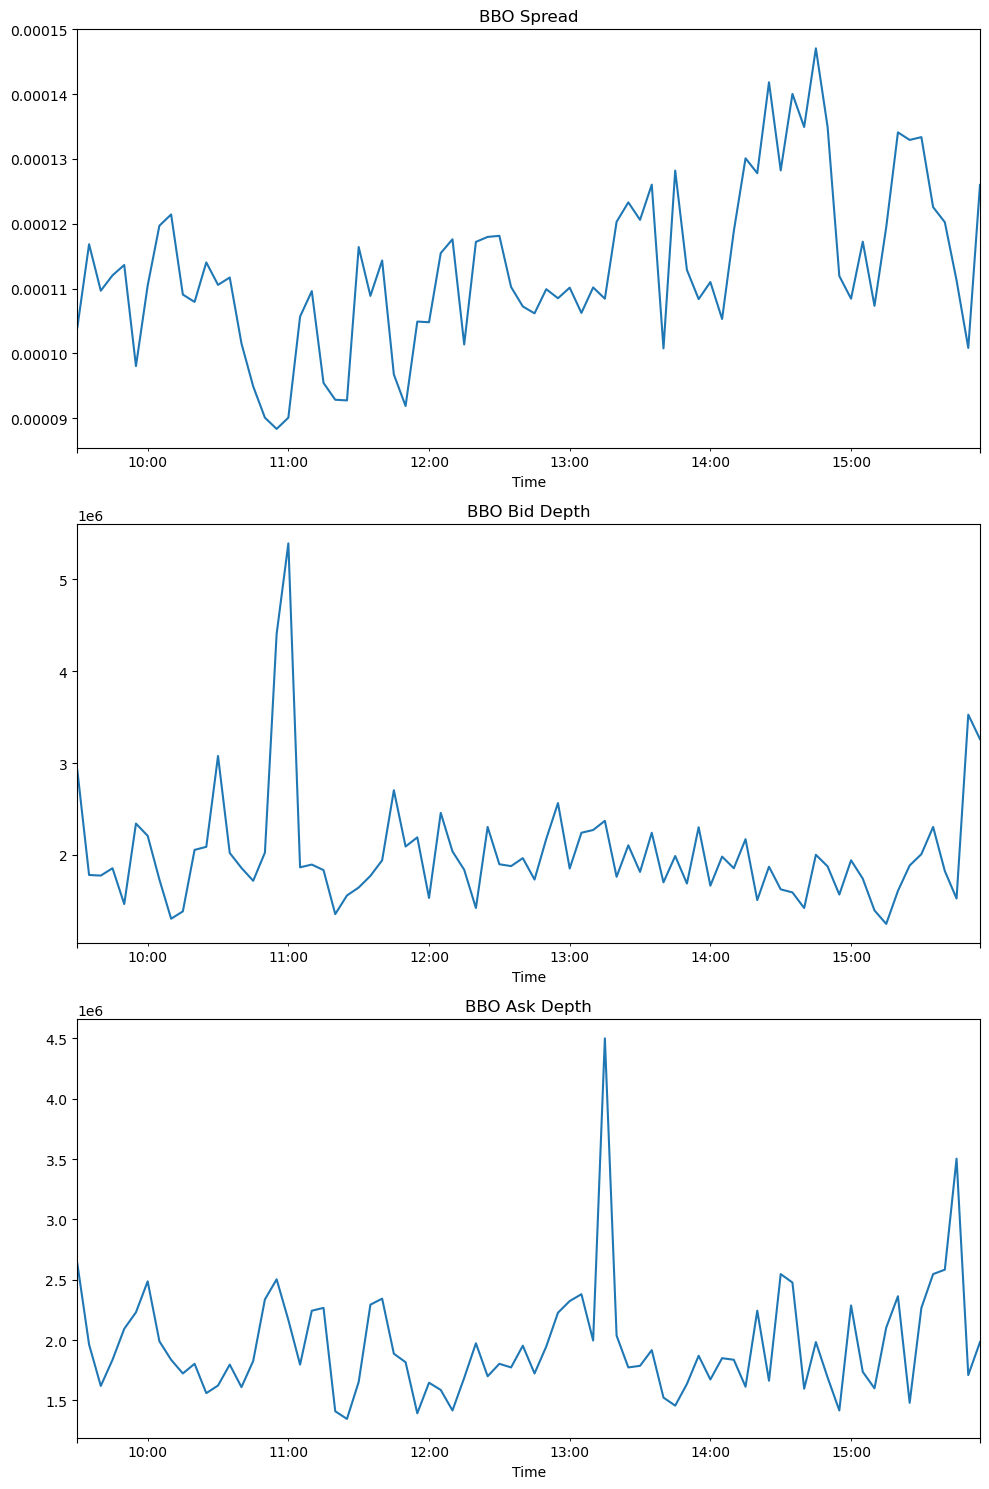

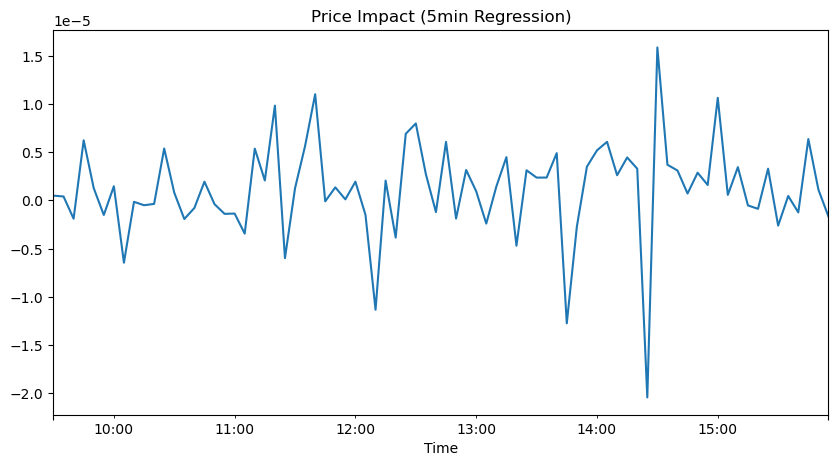

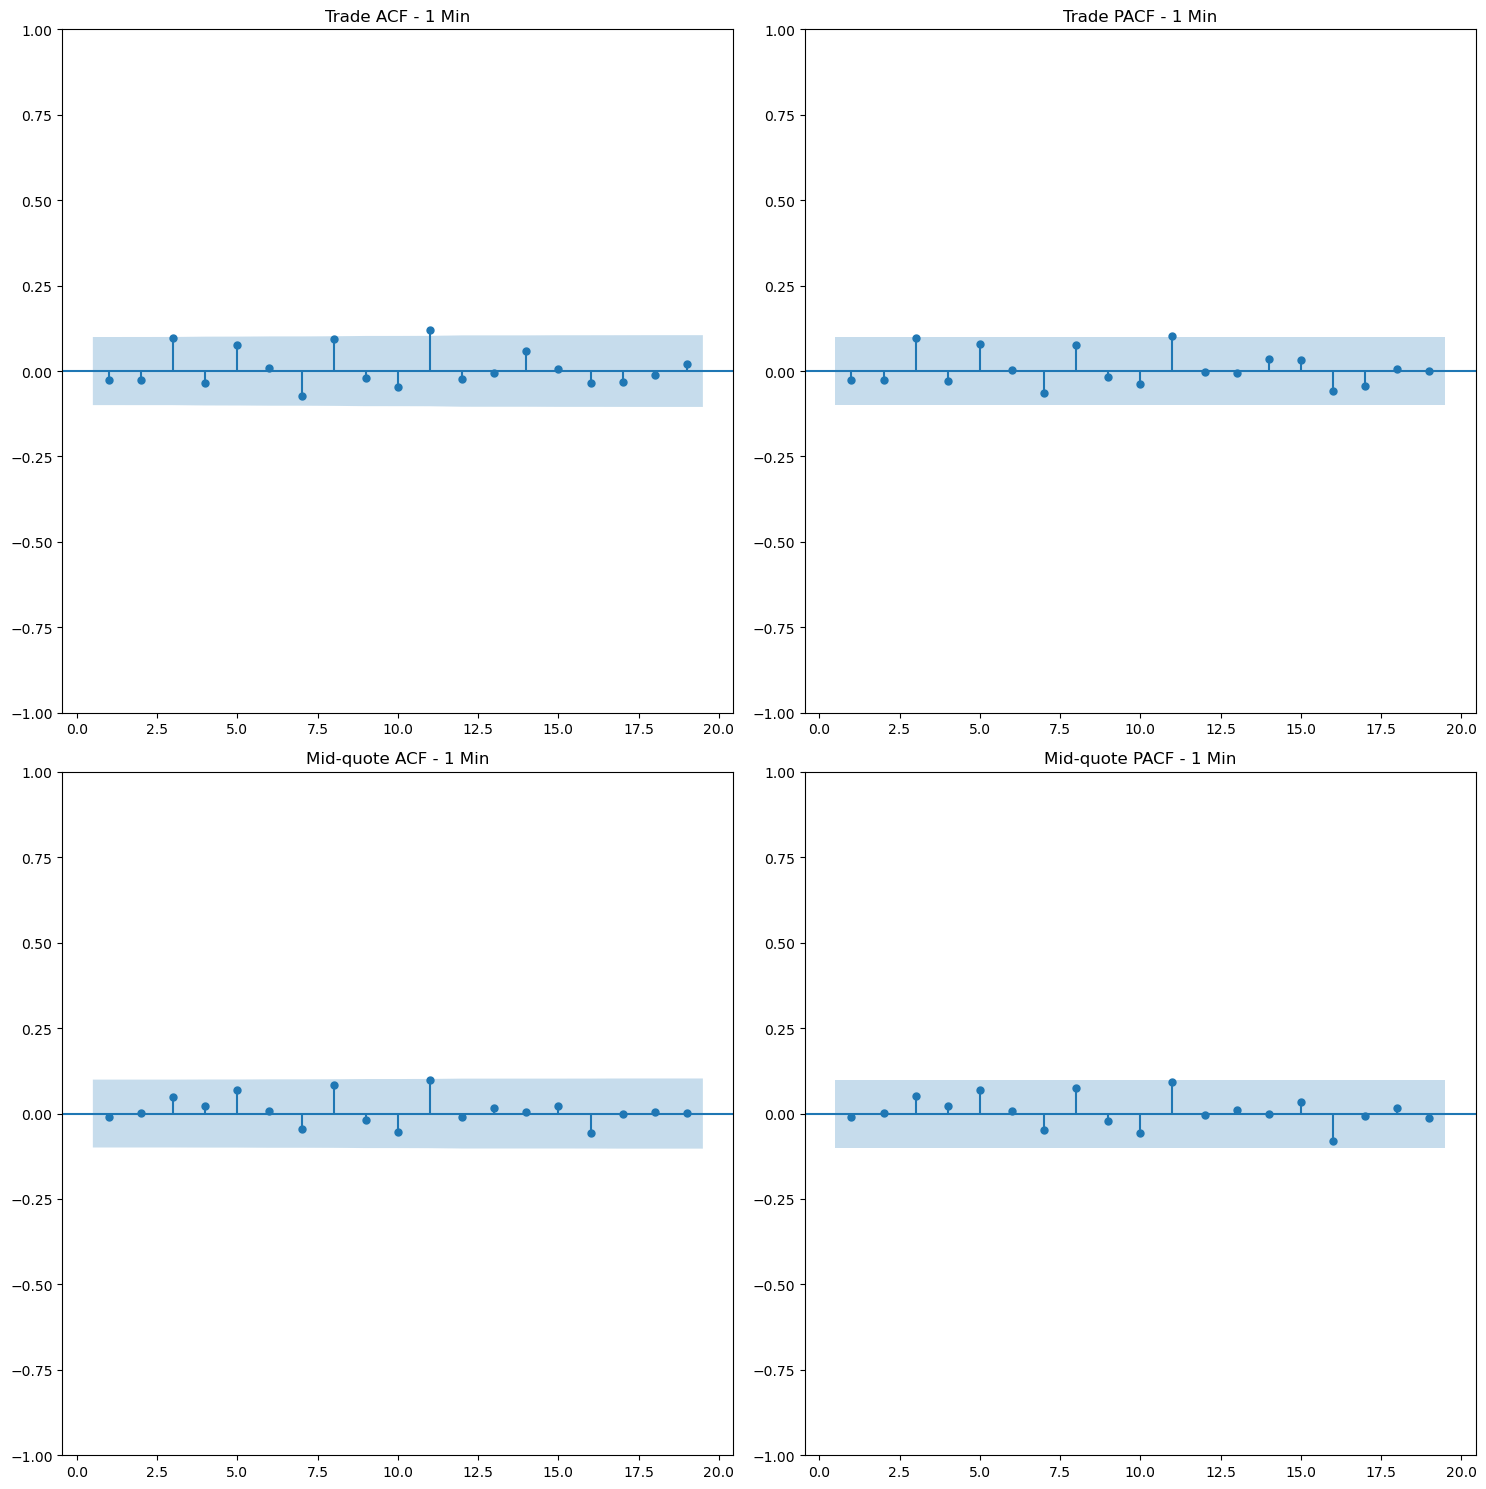

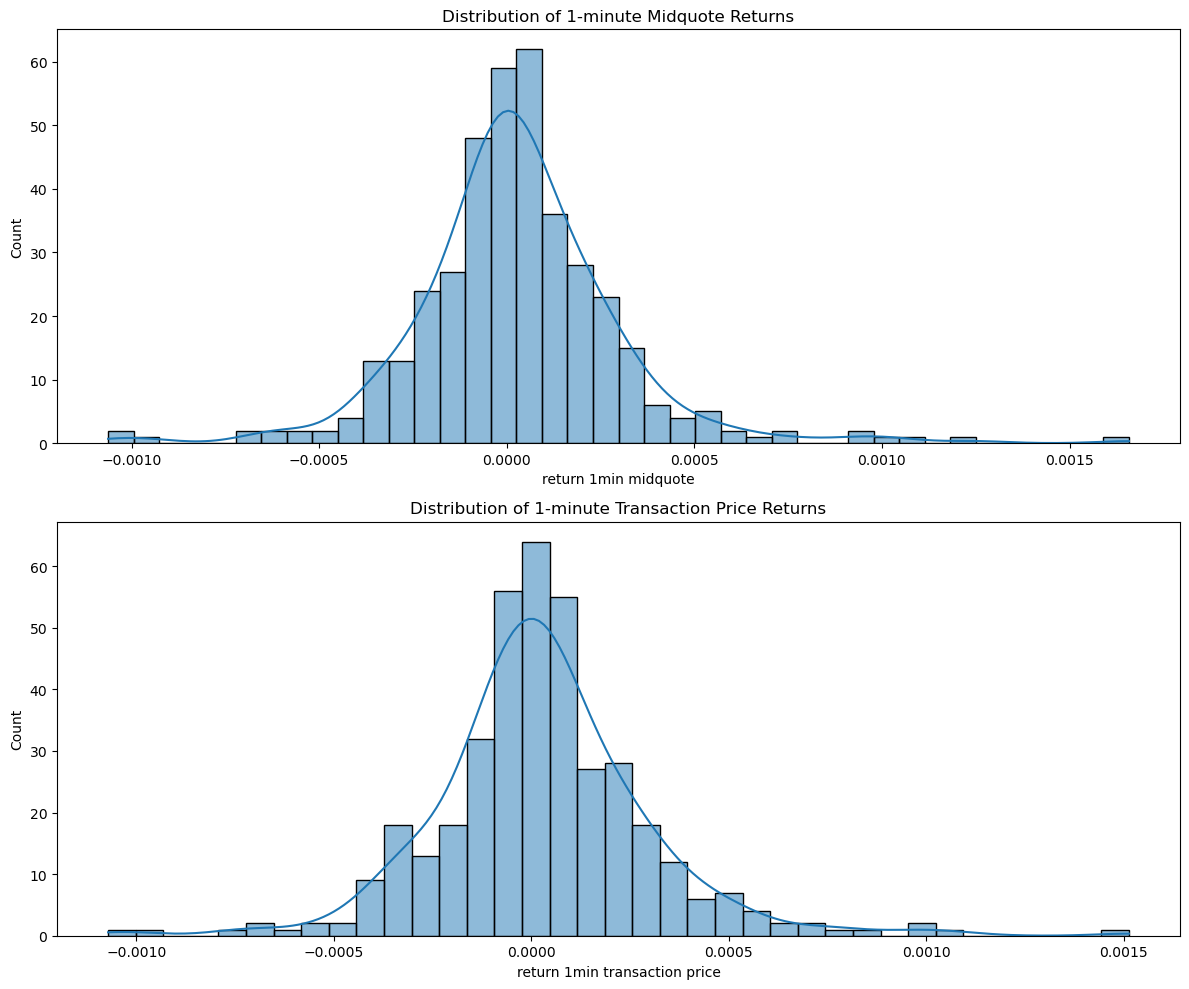

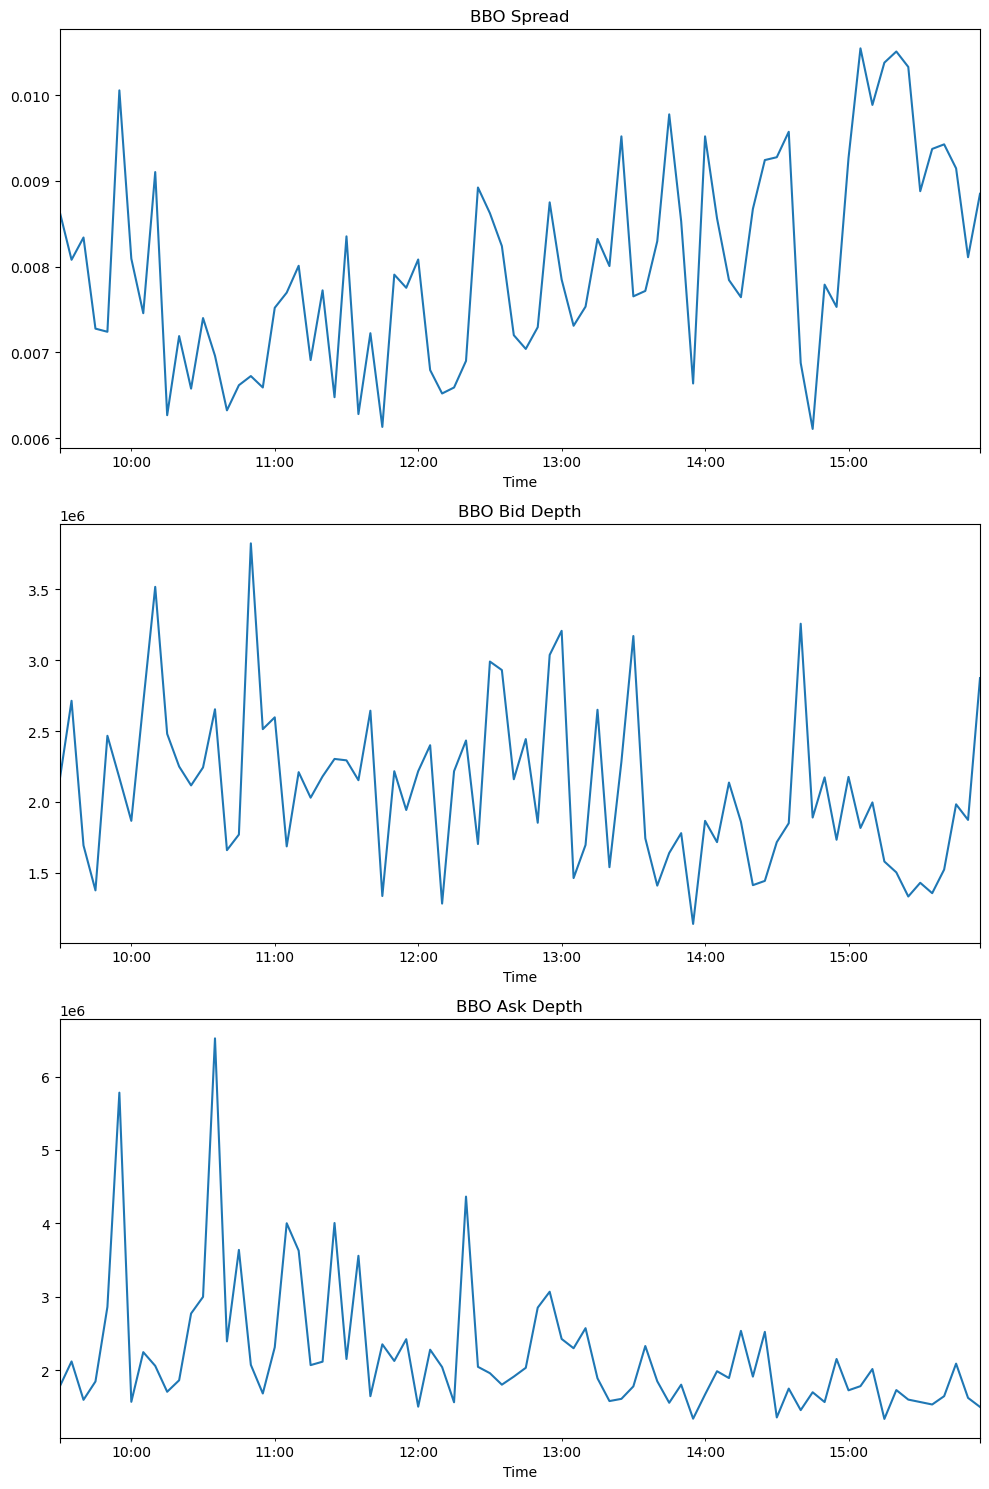

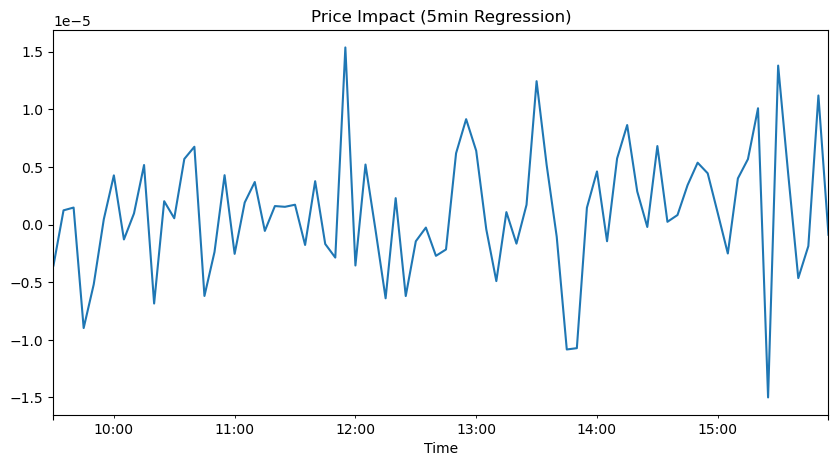

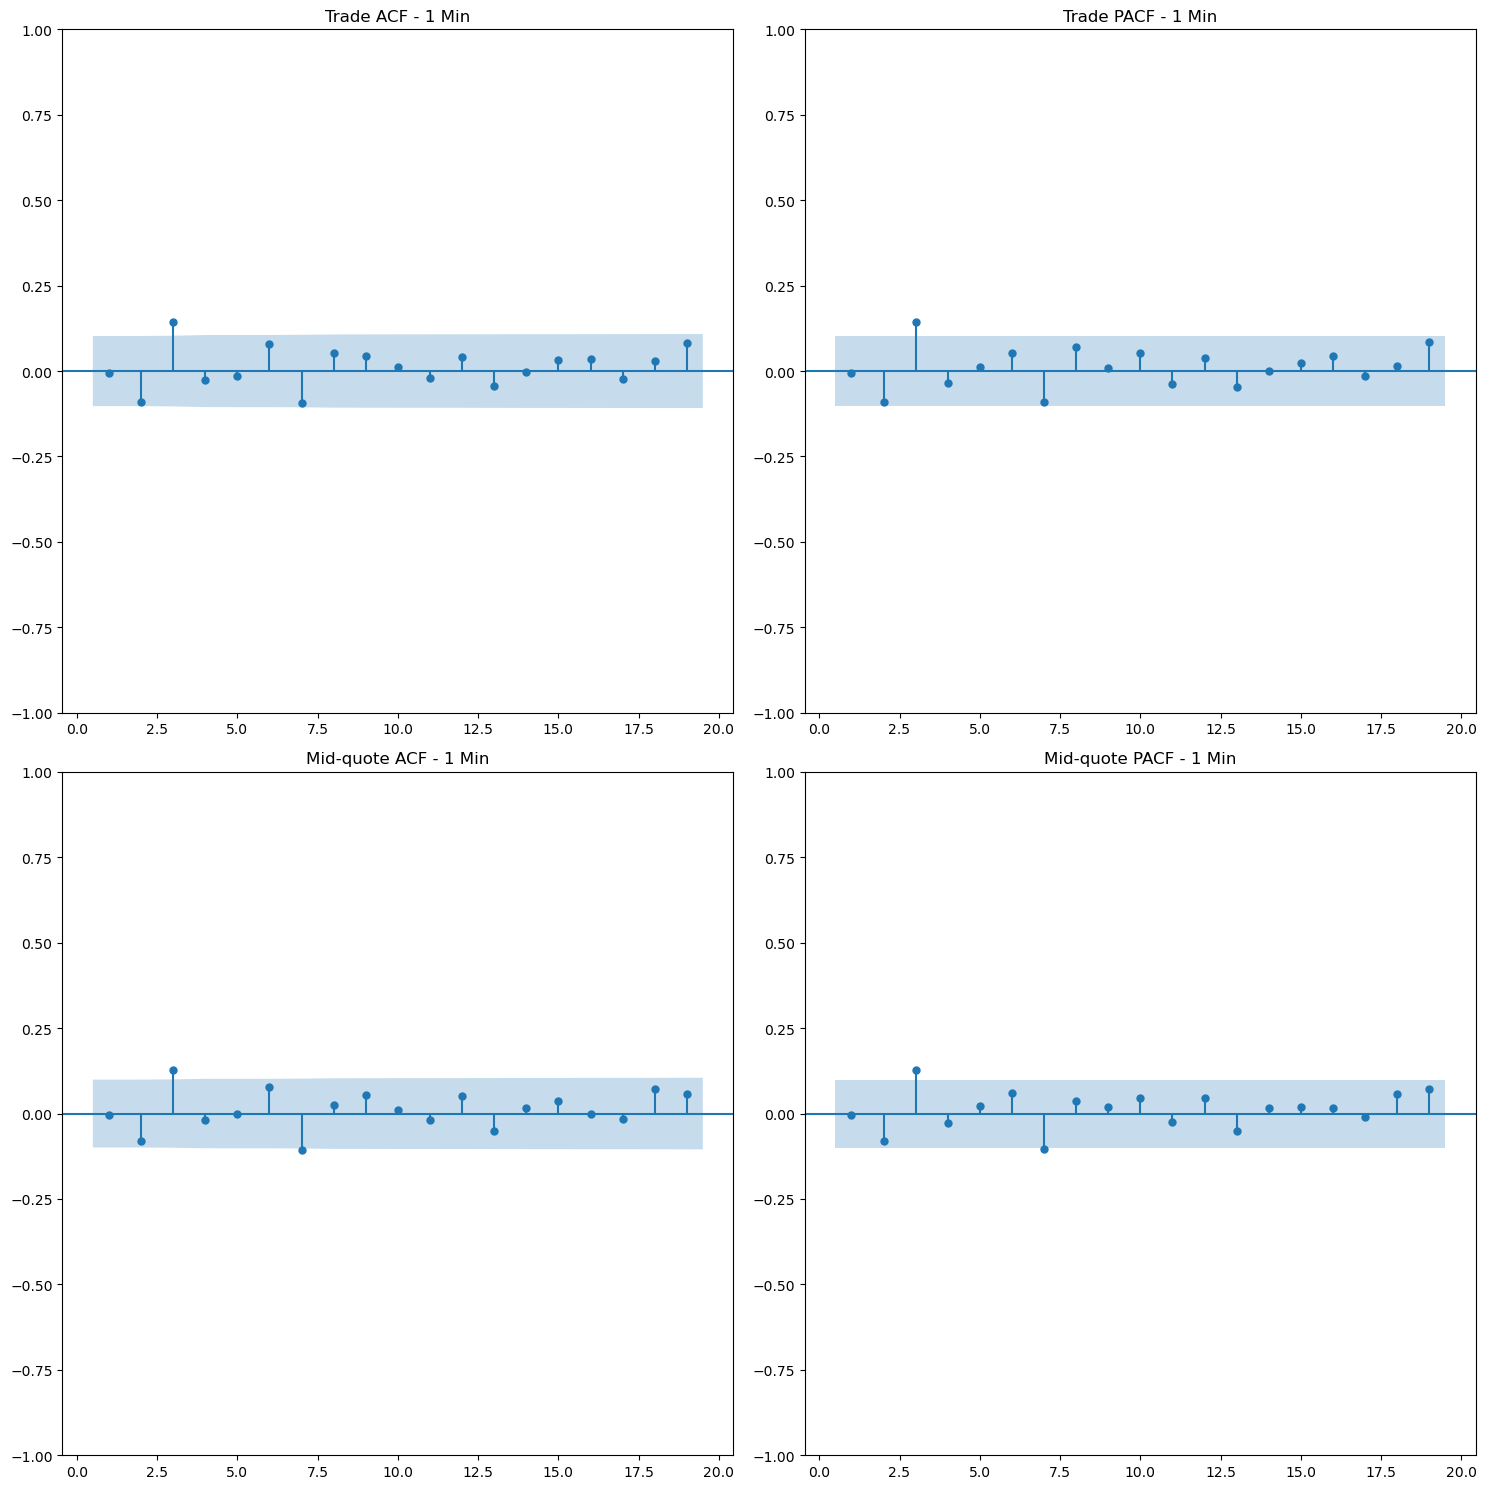

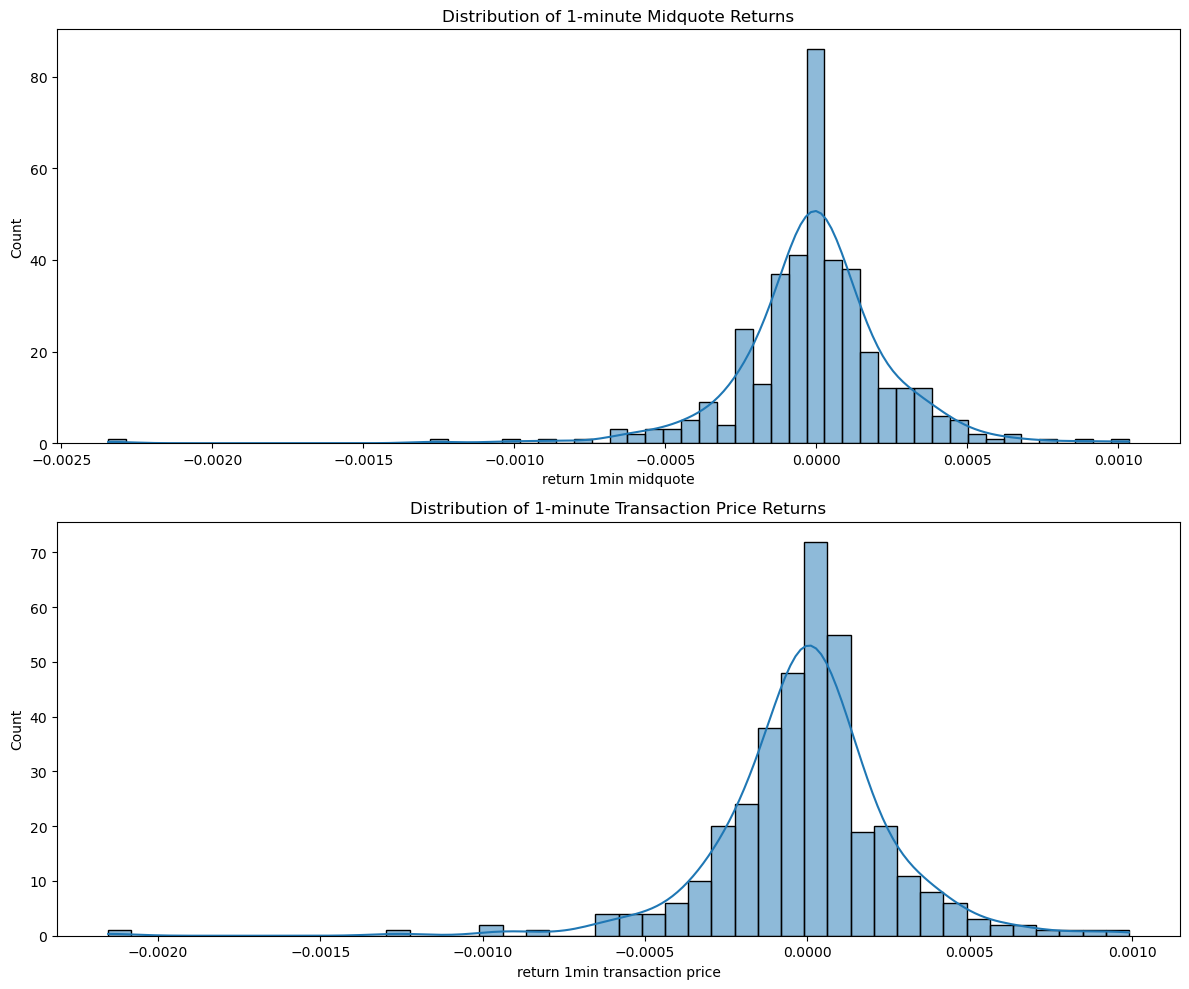

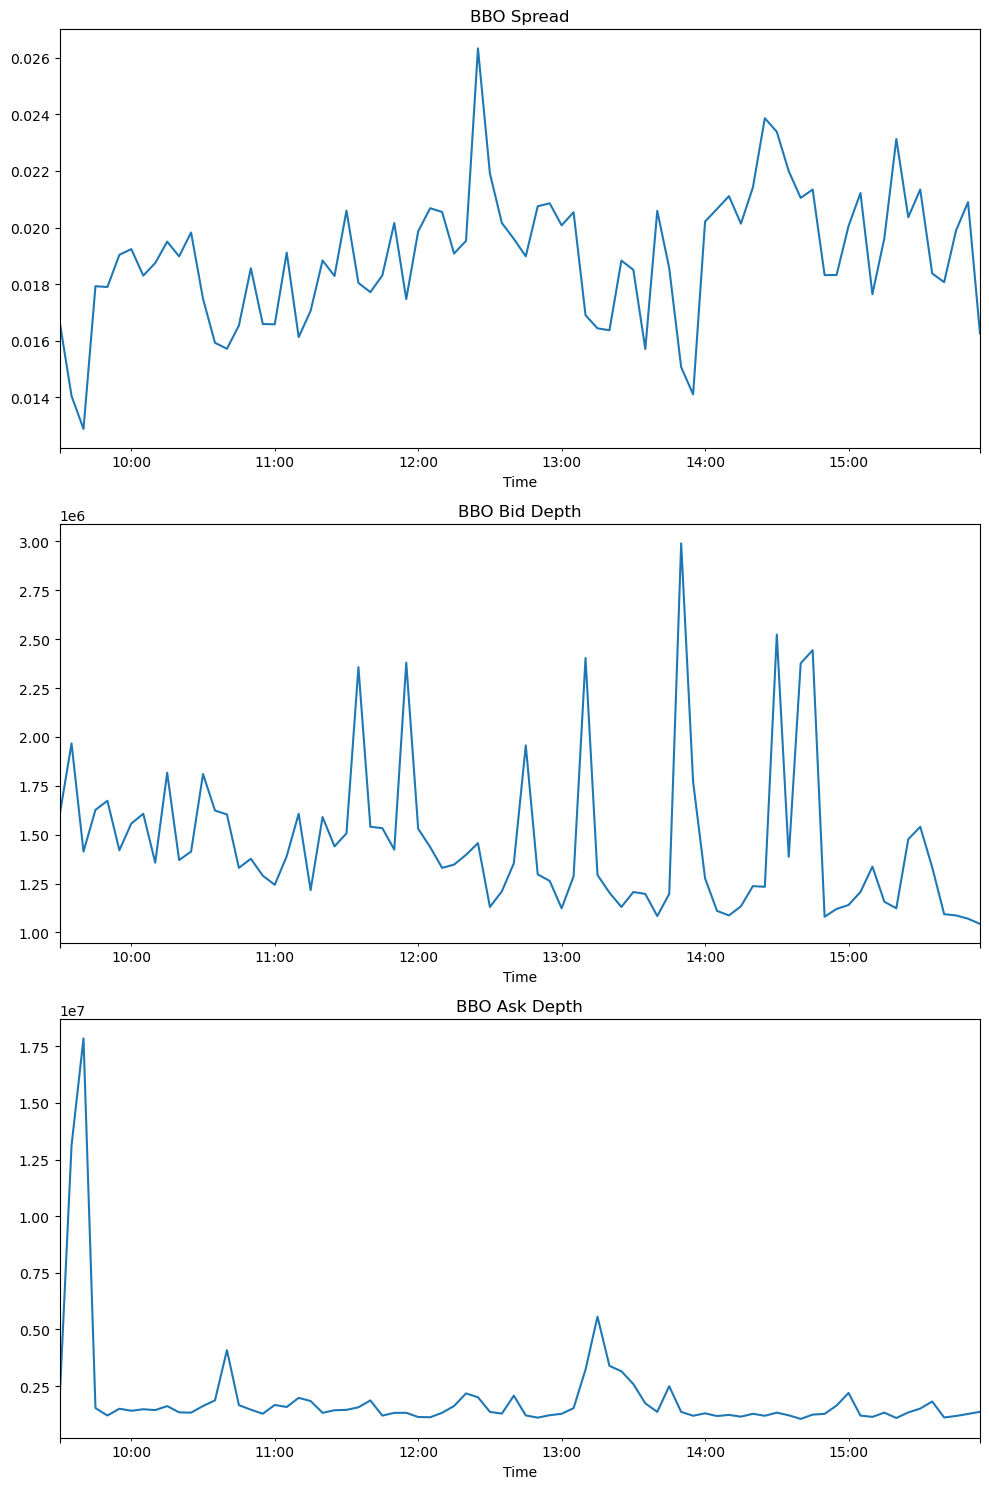

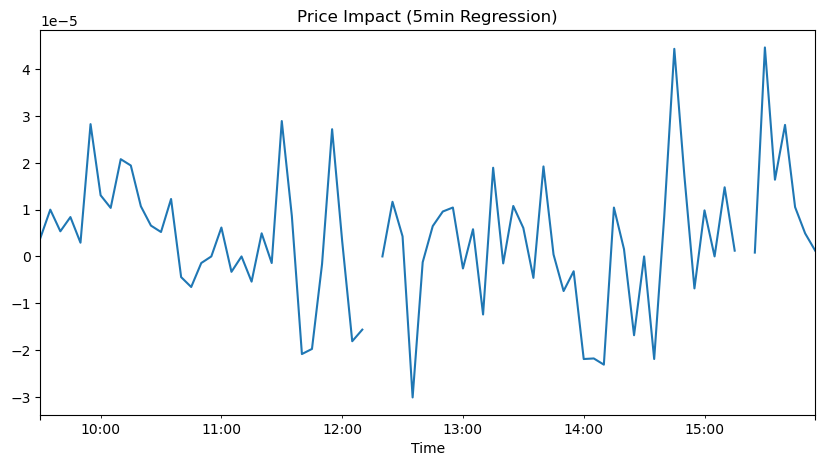

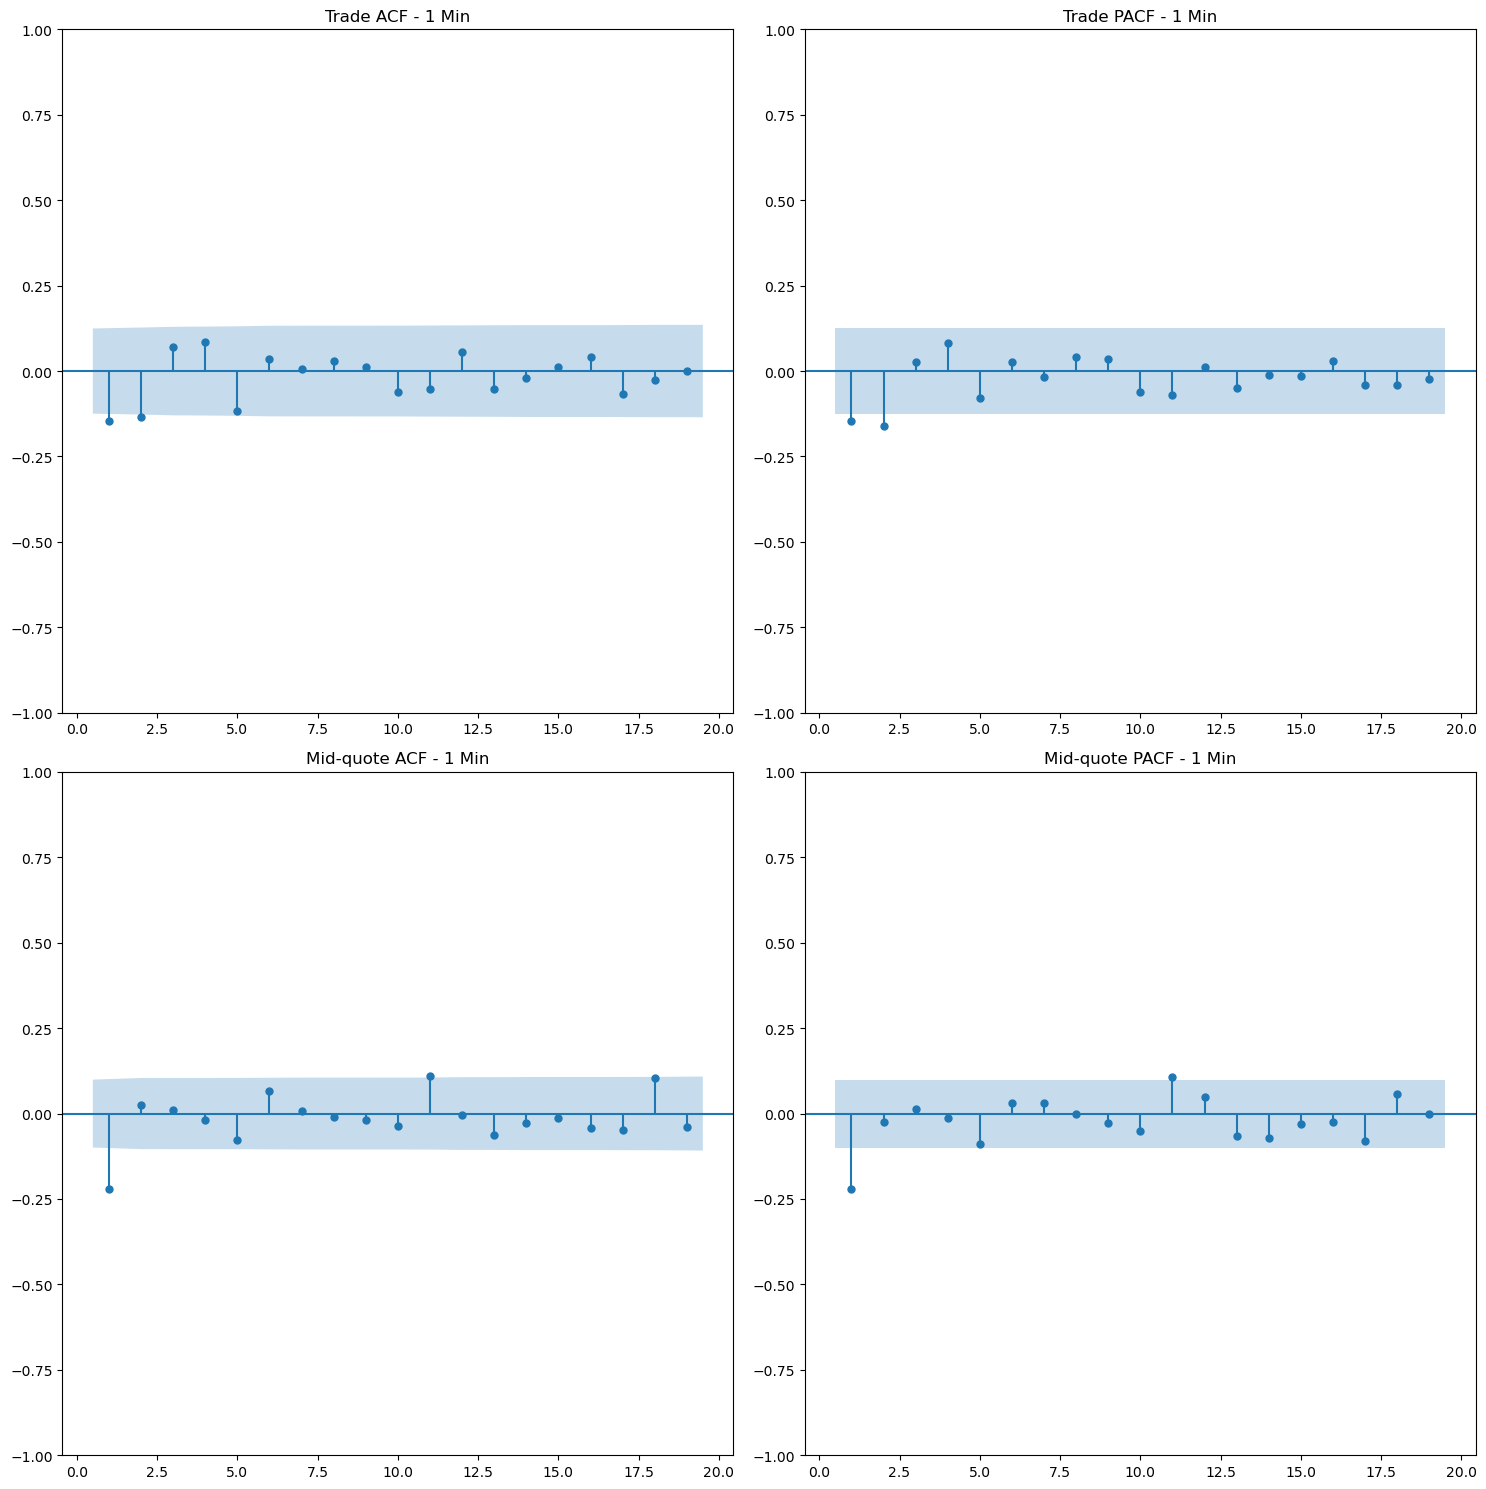

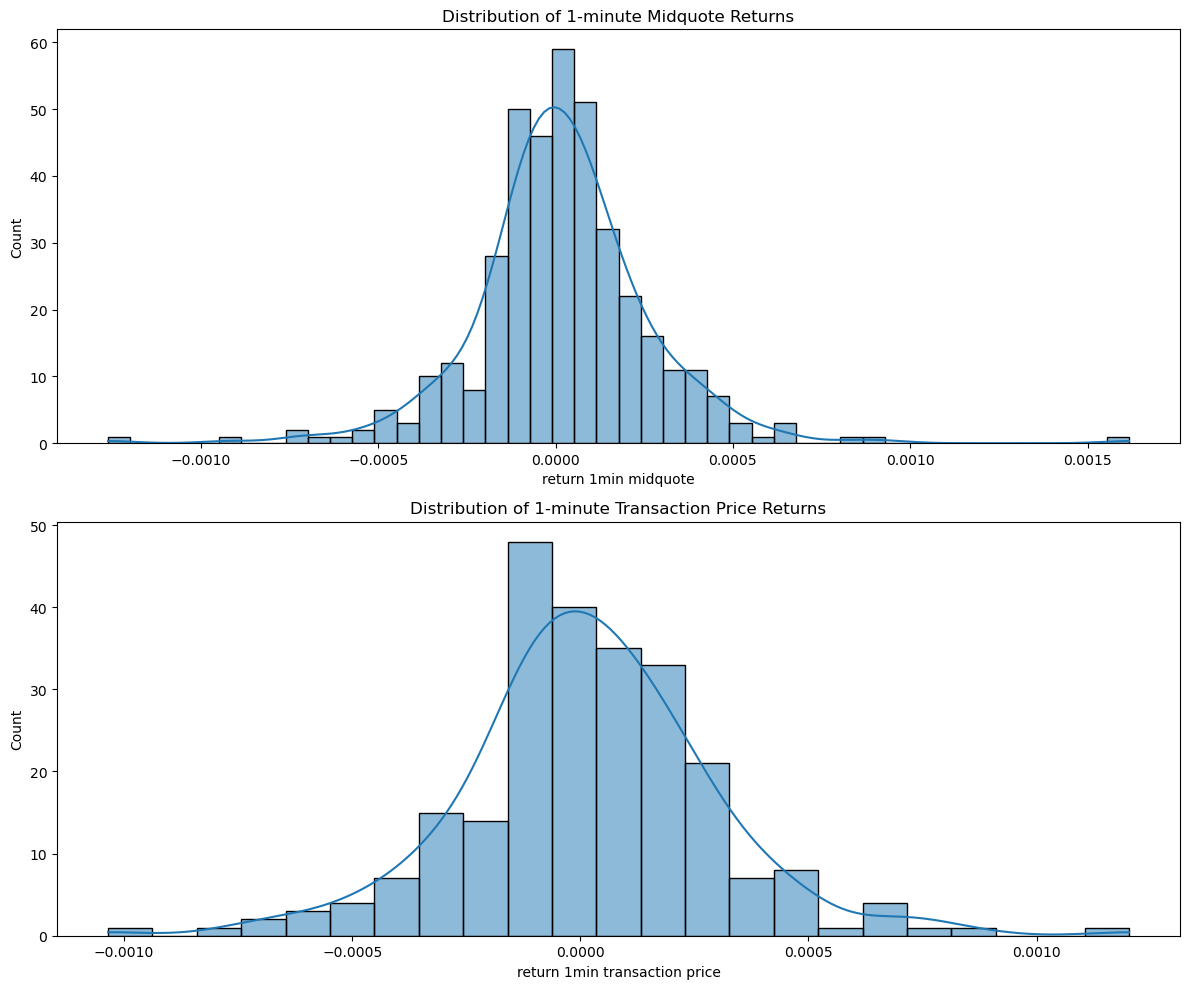

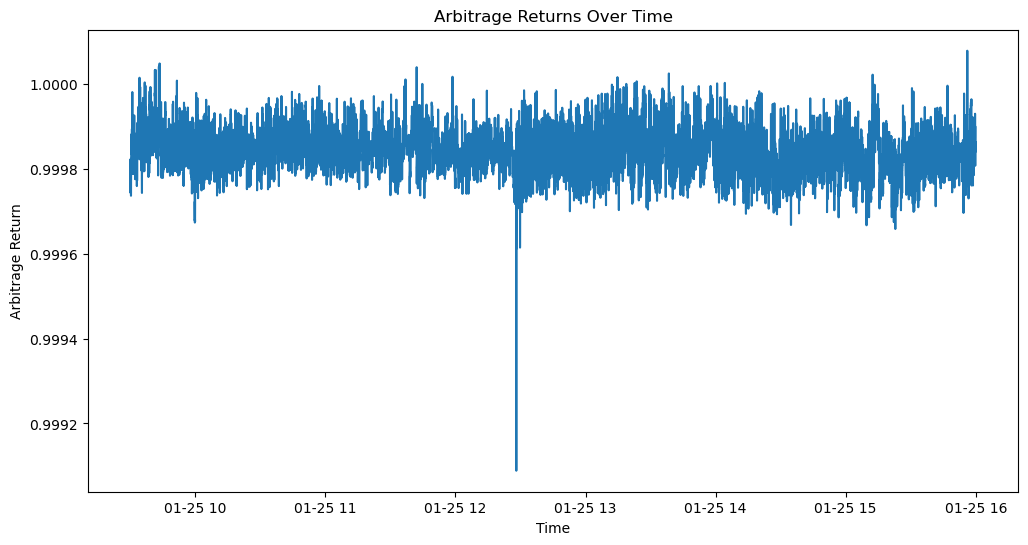

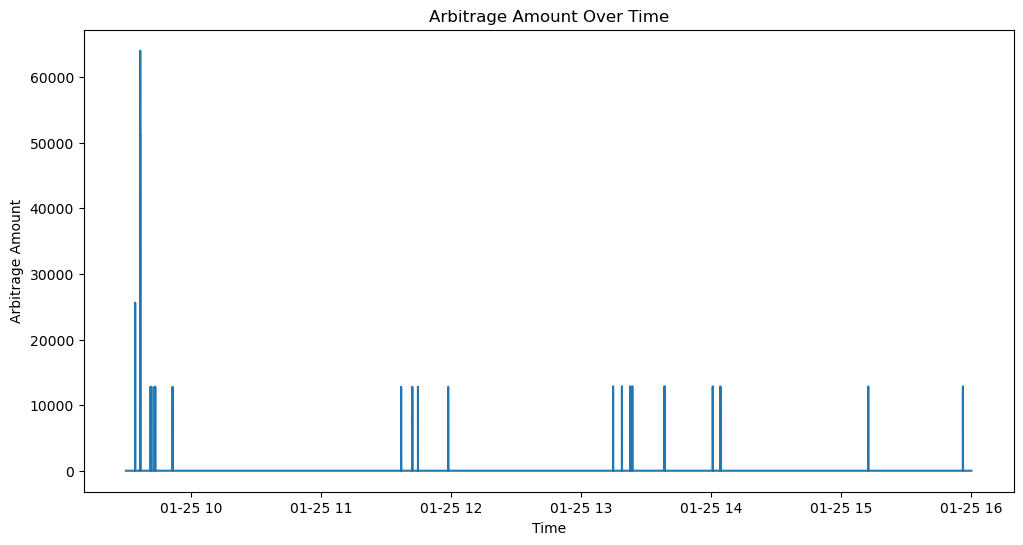

In [63]:

# Process currency data
currency_orderbook, dfs_order_curr = process_currency_data(order_currency)

dfs_trade_curr = clean_and_split_data(trade_currency, ['EUR/USD', 'USD/JPY', 'EUR/JPY'], "EBS_BOOK::")

# Analyze tickers
tickers = ['EUR/USD', 'USD/JPY', 'EUR/JPY']
results = {}

for ticker in tickers:
    results[ticker] = analyze_ticker(dfs_trade_curr[ticker], dfs_order_curr[ticker], ticker)

# Analyze arbitrage opportunities
arbitrage, arbitrage_summary = analyze_arbitrage(currency_orderbook)


# Display results
for ticker, result in results.items():
    print(f"\n{'='*50}\nResults for {ticker}\n{'='*50}")
    print("\nDollar Volume Statistics:")
    print(result['dollar_volume'])
    print("\nTrading Activity Statistics:")
    print(result['trading_activity'])
    print("\nOHLC Statistics:")
    print(result['ohlc'])
    print("\nVWAP Statistics:")
    print(result['vwap'])
    print("\nBBO Statistics:")
    print(result['bbo'])
    print("\nDepth at Twice Spread Statistics:")
    print(result['depth_at_twice_spread'])
    print("\nRealized Variance:")
    print(result['realized_variance'])
    print("\nPrice Impact Summary:")
    print(result['price_impact_summary'])

    # Display plots
    result['liquidity_plot'].show()
    result['price_impact_plot'].show()
    result['acf_pacf_plot'].show()
    result['return_distribution_plot'].show()

print("\n{'='*50}\nArbitrage Summary\n{'='*50}")
print(arbitrage_summary.describe())

# Plot arbitrage opportunities
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(arbitrage.index, arbitrage['arbi_ret'])
ax.set_title('Arbitrage Returns Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Arbitrage Return')
plt.show()

# Plot arbitrage amount
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(arbitrage.index, arbitrage['arbi_amt'])
ax.set_title('Arbitrage Amount Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Arbitrage Amount')
plt.show()
